__Deep Deterministic Policy Gradient__ <br><br>
DDPG uses four neural networks: 
- Q Network
- Deterministic Policy Network
- Target Q Network
- Target Policy Network
<br>

It makes uses of *Actor-Critic Methods*, where the: <br>
- Critic estimates the value function (Q Value or state-value, V)
- while the Actor updates the policy distribution in the direction suggested by the Critic

## Deep Deterministic Policy Gradient (DDPG)

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import gym
from tensorflow.keras.models import load_model
!pip3 install box2d-py

env= gym.make("LunarLanderContinuous-v2")
state_low = env.observation_space.low
state_high = env.observation_space.high
action_low = env.action_space.low 
action_high = env.action_space.high
print(state_low)
print(state_high)
print(action_low)
print(action_high)

class RBuffer():
    def __init__(self, maxsize, statedim, naction):
        self.cnt = 0
        self.maxsize = maxsize
        self.state_memory = np.zeros((maxsize, *statedim), dtype=np.float32)
        self.action_memory = np.zeros((maxsize, naction), dtype=np.float32)
        self.reward_memory = np.zeros((maxsize,), dtype=np.float32)
        self.next_state_memory = np.zeros((maxsize, *statedim), dtype=np.float32)
        self.done_memory = np.zeros((maxsize,), dtype= np.bool)

    def storexp(self, state, next_state, action, done, reward):
        index = self.cnt % self.maxsize
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.done_memory[index] = 1- int(done)
        self.cnt += 1

    def sample(self, batch_size):
        max_mem = min(self.cnt, self.maxsize)
        batch = np.random.choice(max_mem, batch_size, replace= False)  
        states = self.state_memory[batch]
        next_states = self.next_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        dones = self.done_memory[batch]
        return states, next_states, rewards, actions, dones

class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.v =  tf.keras.layers.Dense(1, activation=None)

    def call(self, inputstate, action):
        x = self.f1(tf.concat([inputstate, action], axis=1))
        x = self.f2(x)
        x = self.v(x)
        return x


class Actor(tf.keras.Model):
    def __init__(self, no_action):
        super(Actor, self).__init__()    
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.mu =  tf.keras.layers.Dense(no_action, activation='tanh')

    def call(self, state):
        x = self.f1(state)
        x = self.f2(x)
        x = self.mu(x)  
        return x

class Agent():
    def __init__(self, n_action= len(env.action_space.high)):
        self.actor_main = Actor(n_action)
        self.actor_target = Actor(n_action)
        self.critic_main = Critic()
        self.critic_target = Critic()
        self.batch_size = 64
        self.n_actions = len(env.action_space.high)
        self.a_opt = tf.keras.optimizers.Adam(1e-4)
        # self.actor_target = tf.keras.optimizers.Adam(.001)
        self.c_opt = tf.keras.optimizers.Adam(1e-4)
        # self.critic_target = tf.keras.optimizers.Adam(.002)
        self.memory = RBuffer(1_00_000, env.observation_space.shape, len(env.action_space.high))
        self.trainstep = 0
        self.replace = 5
        self.gamma = 0.99
        self.min_action = env.action_space.low[0]
        self.max_action = env.action_space.high[0]

    def act(self, state, evaluate=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor_main(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=0.1)

        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
        #print(actions)
        return actions[0]


    def savexp(self,state, next_state, action, done, reward):
        self.memory.storexp(state, next_state, action, done, reward)

    def update_target(self):
        self.actor_target.set_weights(self.actor_main.get_weights())
        self.critic_target.set_weights(self.critic_main.get_weights())

    def train(self):
        if self.memory.cnt < self.batch_size:
            return 

        states, next_states, rewards, actions, dones = self.memory.sample(self.batch_size)
        
        states = tf.convert_to_tensor(states, dtype= tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype= tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype= tf.float32)
        actions = tf.convert_to_tensor(actions, dtype= tf.float32)
        #dones = tf.convert_to_tensor(dones, dtype= tf.bool)

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            target_actions = self.actor_target(next_states)
            target_next_state_values = tf.squeeze(self.critic_target(next_states, target_actions), 1)
            critic_value = tf.squeeze(self.critic_main(states, actions), 1)
            target_values = rewards + self.gamma * target_next_state_values * dones
            critic_loss = tf.keras.losses.MSE(target_values, critic_value)

            new_policy_actions = self.actor_main(states)
            actor_loss = -self.critic_main(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss)

        grads1 = tape1.gradient(actor_loss, self.actor_main.trainable_variables)
        grads2 = tape2.gradient(critic_loss, self.critic_main.trainable_variables)
        self.a_opt.apply_gradients(zip(grads1, self.actor_main.trainable_variables))
        self.c_opt.apply_gradients(zip(grads2, self.critic_main.trainable_variables))

        if self.trainstep % self.replace == 0:
            self.update_target()
        
        self.trainstep +=1
    
agent = Agent(2)
tf.random.set_seed(336699)

episods = 2000
ep_reward = []
total_avgr = []
successCount = 0
target = False

for s in range(episods):
    if target == True:
        break
    total_reward = 0 
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.savexp(state, next_state, action, done, reward)
        agent.train()
        state = next_state
        total_reward += reward
        if reward >= 200:
            sucessCount += 1
        if done:
            ep_reward.append(total_reward)
            avg_reward = np.mean(ep_reward[-100:])
            total_avgr.append(avg_reward)
            print("total reward after {} steps is {} and avg reward is {}".format(s, total_reward, avg_reward))
            
            if int(avg_reward) == 200:
                target = True

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\rutsm\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\rutsm\\AppData\\Local\\Temp\\pip-install-4txw2gas\\box2d-py_257f398f7906462f99bc369c4887041d\\setup.py'"'"'; __file__='"'"'C:\\Users\\rutsm\\AppData\\Local\\Temp\\pip-install-4txw2gas\\box2d-py_257f398f7906462f99bc369c4887041d\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\rutsm\AppData\Local\Temp\pip-wheel-ewobga04'
       cwd: C:\Users\rutsm\AppData\Local\Temp\pip-install-4txw2gas\box2d-py_257f398f7906462f99bc369c4887041d\
  Complete output (28 lines):
  Using setuptools (version 58.0.4).
  running bdist_wheel
  running build
  running build_py
  creating build


[inf inf inf inf inf inf inf inf]
[-1. -1.]
[1. 1.]

  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Running setup.py clean for box2d-py
Failed to build box2d-py
    Running setup.py install for box2d-py: started
    Running setup.py install for box2d-py: finished with status 'error'
total reward after 0 steps is -139.2051433678286 and avg reward is -139.2051433678286
total reward after 1 steps is -478.54187930310917 and avg reward is -308.8735113354689
total reward after 2 steps is 14.740088677505312 and avg reward is -201.00231133114414
total reward after 3 steps is -653.387648159637 and avg reward is -314.09864553826736
total reward after 4 steps is -123.6607575109827 and avg reward is -276.0110679328104
total reward after 5 steps is -186.27581316880207 and avg reward is -261.055192138809
total reward after 6 steps is -368.1243095101677 and avg reward is -276.3507803347174
total reward after 7 steps is -143.2851947623406 and avg reward is -259.7175821381703
total reward after 8 step

total reward after 88 steps is -150.2567235389339 and avg reward is -207.6813882062506
total reward after 89 steps is -162.40906502652308 and avg reward is -207.17836239314255
total reward after 90 steps is -164.8220464714375 and avg reward is -206.71290837202488
total reward after 91 steps is -161.93572524468954 and avg reward is -206.22619985977124
total reward after 92 steps is -103.9440106178679 and avg reward is -205.12639137329916
total reward after 93 steps is -176.71526533889246 and avg reward is -204.8241453516565
total reward after 94 steps is -223.72248229320581 and avg reward is -205.02307521419914
total reward after 95 steps is -166.09311039135304 and avg reward is -204.61755474729452
total reward after 96 steps is -119.51018147488296 and avg reward is -203.740159146548
total reward after 97 steps is -186.67596762421897 and avg reward is -203.5660347432589
total reward after 98 steps is -94.00722892063102 and avg reward is -202.45938013898996
total reward after 99 steps is

total reward after 181 steps is -61.11757451344349 and avg reward is -120.8052372715343
total reward after 182 steps is -136.72815382882425 and avg reward is -119.79021525876787
total reward after 183 steps is -123.62967505406145 and avg reward is -119.01812569138981
total reward after 184 steps is -31.71630499872265 and avg reward is -117.58415055668978
total reward after 185 steps is -101.85003449122425 and avg reward is -116.82219565137024
total reward after 186 steps is 139.3231760130821 and avg reward is -113.6787446460713
total reward after 187 steps is -56.034903743901154 and avg reward is -113.0501047232089
total reward after 188 steps is -33.40098455086998 and avg reward is -111.88154733332826
total reward after 189 steps is -50.25696770787402 and avg reward is -110.76002636014175
total reward after 190 steps is -42.65109780758651 and avg reward is -109.53831687350325
total reward after 191 steps is 123.88553151125913 and avg reward is -106.68010430594376
total reward after 19

total reward after 274 steps is -47.32330359786057 and avg reward is -83.84393298029475
total reward after 275 steps is -261.99440418454117 and avg reward is -85.72906651880734
total reward after 276 steps is -214.1075868313623 and avg reward is -87.3947803249747
total reward after 277 steps is -227.7683546243543 and avg reward is -88.76579774621423
total reward after 278 steps is -63.70024225514974 and avg reward is -88.90780311957255
total reward after 279 steps is -28.577989821922003 and avg reward is -89.1643250545146
total reward after 280 steps is -57.19739319842848 and avg reward is -89.30601686151373
total reward after 281 steps is -79.54145945394984 and avg reward is -89.49025571091879
total reward after 282 steps is -65.37278111679055 and avg reward is -88.77670198379843
total reward after 283 steps is -186.37047583206243 and avg reward is -89.40410999157844
total reward after 284 steps is -151.15385562221866 and avg reward is -90.5984854978134
total reward after 285 steps is

total reward after 368 steps is 260.3602192950209 and avg reward is 4.55689122126622
total reward after 369 steps is 76.39025803089082 and avg reward is 5.29048775469174
total reward after 370 steps is 219.30255743116558 and avg reward is 8.527392603101099
total reward after 371 steps is -112.29056381978681 and avg reward is 7.844547689570607
total reward after 372 steps is 235.5861346992383 and avg reward is 9.967754444346268
total reward after 373 steps is -2.0037027017353384 and avg reward is 10.188791113183745
total reward after 374 steps is 267.0236273325595 and avg reward is 13.332260422487945
total reward after 375 steps is 202.68396370405787 and avg reward is 17.979044101373933
total reward after 376 steps is 257.26928715837414 and avg reward is 22.692812841271298
total reward after 377 steps is 133.05267871881927 and avg reward is 26.301023174703033
total reward after 378 steps is 250.6800760162242 and avg reward is 29.444826357416773
total reward after 379 steps is 243.398380

total reward after 463 steps is 121.26174458222476 and avg reward is 125.98339864468707
total reward after 464 steps is 84.6067623991123 and avg reward is 124.21173183323383
total reward after 465 steps is 196.6808862745075 and avg reward is 124.15673648090471
total reward after 466 steps is 60.47115113736005 and avg reward is 125.56733336614045
total reward after 467 steps is 275.5714576057562 and avg reward is 126.36701986795464
total reward after 468 steps is 116.9379337793635 and avg reward is 124.93279701279806
total reward after 469 steps is 249.91219658655604 and avg reward is 126.66801639835471
total reward after 470 steps is 192.42866733246194 and avg reward is 126.39927749736766
total reward after 471 steps is -19.820395133542135 and avg reward is 127.32397918423013
total reward after 472 steps is 230.4921289966369 and avg reward is 127.2730391272041
total reward after 473 steps is 111.81303030226593 and avg reward is 128.4112064572441
total reward after 474 steps is 119.6464

total reward after 557 steps is 29.391942687500062 and avg reward is 65.54080461019727
total reward after 558 steps is -26.981285606493856 and avg reward is 62.89168070481512
total reward after 559 steps is -54.15214682206426 and avg reward is 60.06560709832481
total reward after 560 steps is 144.85701598429196 and avg reward is 63.219589180836756
total reward after 561 steps is 210.5483461503427 and avg reward is 63.53414443172158
total reward after 562 steps is 245.78003271931854 and avg reward is 64.37992768415863
total reward after 563 steps is 234.03746299396406 and avg reward is 65.50768486827602
total reward after 564 steps is 186.56124426495808 and avg reward is 66.52722968693448
total reward after 565 steps is 172.1573481151296 and avg reward is 66.28199430534069
total reward after 566 steps is 245.12703537277756 and avg reward is 68.12855314769489
total reward after 567 steps is 273.342934190005 and avg reward is 68.10626791353735
total reward after 568 steps is 178.464192164

Text(0, 0.5, 'Score')

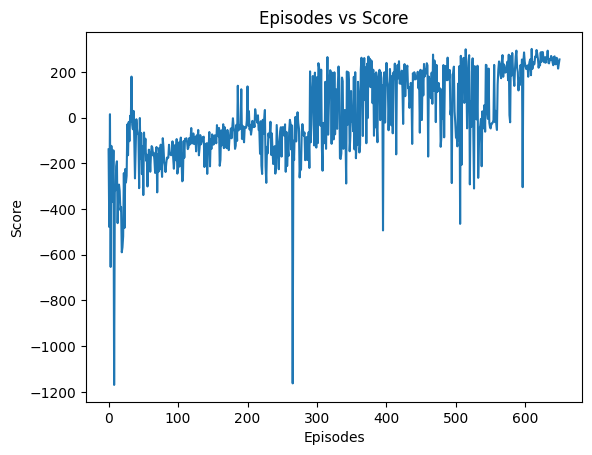

In [6]:
plt.plot(ep_reward)
plt.title('Episodes vs Score')
plt.xlabel('Episodes')
plt.ylabel('Score')

Text(0, 0.5, 'Average Score')

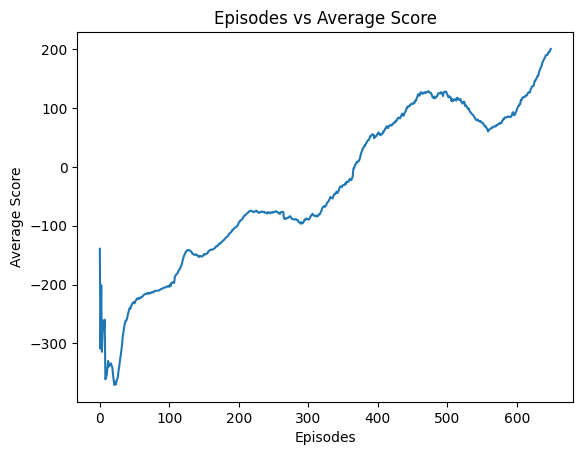

In [7]:
plt.plot(total_avgr)
plt.title('Episodes vs Average Score')
plt.xlabel('Episodes')
plt.ylabel('Average Score')

## Proximal Policy Optimization (PPO)

__Proximal Policy Optimization__ <br>
The goal of PPO is to optimize a policy to maximize the rewards. To do this, there are two major optimization techniques. <br><br>

__Line Search/Gradient Descent__ <br>
Line search picks the steepest direction and move a step. However, if the step size is too small, it takes too long, but if the step size is too large, it is overshot, resulting in the resumption from a locally bad policy, harming performance significantly. <br><br>

__Trust Region__ <br>
Here, the max step size is determined, before locating the optimal point without the trust region and resume from there. If the divergence between the new and current policy is too large, the region can be shrunk in order to prevent it from making bad decisions. <br>

In PPO, the magnitude of how much the policy can change between iterations is limited using KL Divergence. KL Divergence is repurposed to measure the difference between two policies. This is because we do not want a new policy to be too different from the current.

episode: 1/5000, score: -108.33248336064531, average: -108.33 
episode: 2/5000, score: -130.81191425342598, average: -119.57 
episode: 3/5000, score: -52.67031206247117, average: -97.27 
episode: 4/5000, score: -161.43983270666712, average: -113.31 
episode: 5/5000, score: -114.98736091868898, average: -113.65 
episode: 6/5000, score: -369.84607257807943, average: -156.35 
episode: 7/5000, score: -99.27031181722577, average: -148.19 
episode: 8/5000, score: -133.53871918444472, average: -146.36 
episode: 9/5000, score: -366.69587090577136, average: -170.84 
episode: 10/5000, score: -208.18662488295513, average: -174.58 
episode: 11/5000, score: -291.85279265297123, average: -185.24 
episode: 12/5000, score: -61.467103909377556, average: -174.92 
episode: 13/5000, score: -19.306851492933575, average: -162.95 
episode: 14/5000, score: -160.63645936979586, average: -162.79 
episode: 15/5000, score: -199.23722914367085, average: -165.22 
episode: 16/5000, score: -328.53631625863625, averag

episode: 130/5000, score: -12.390110052422298, average: -108.17 
episode: 131/5000, score: -128.53209670502036, average: -109.92 
episode: 132/5000, score: 101.46987232582539, average: -104.47 
episode: 133/5000, score: -53.16721349192674, average: -104.65 
episode: 134/5000, score: -16.70107696404819, average: -103.86 
episode: 135/5000, score: -55.354192637010925, average: -103.22 
episode: 136/5000, score: -24.051538129390003, average: -101.47 
episode: 137/5000, score: -88.0411328504122, average: -101.61 
episode: 138/5000, score: 2.0796713034537557, average: -96.56 
episode: 139/5000, score: -10.5240520733809, average: -96.26 
episode: 140/5000, score: -75.02594396933836, average: -97.54 
episode: 141/5000, score: -66.76586551329434, average: -98.84 
episode: 142/5000, score: -25.59838980015616, average: -94.64 
episode: 143/5000, score: -33.86964696568079, average: -89.64 
episode: 144/5000, score: -69.29805709606221, average: -85.78 
episode: 145/5000, score: -45.89177762688052,

episode: 260/5000, score: -92.58090898941377, average: -105.13 
episode: 261/5000, score: -120.43687264879605, average: -105.02 
episode: 262/5000, score: -112.00528040174635, average: -105.57 
episode: 263/5000, score: -82.86253428593065, average: -104.91 
episode: 264/5000, score: -126.4811019360493, average: -106.62 
episode: 265/5000, score: -78.78393791632689, average: -107.40 
episode: 266/5000, score: -112.14478774487738, average: -106.99 
episode: 267/5000, score: -95.19772484456388, average: -107.82 
episode: 268/5000, score: -121.27593091672483, average: -108.76 
episode: 269/5000, score: -117.59927315939949, average: -106.86 
episode: 270/5000, score: -206.18598963745592, average: -107.59 
episode: 271/5000, score: -91.37094183594718, average: -107.42 
episode: 272/5000, score: -120.50888672948267, average: -109.00 
episode: 273/5000, score: -166.40400745029564, average: -110.34 
episode: 274/5000, score: -126.42054656240269, average: -112.38 
episode: 275/5000, score: -104.

episode: 389/5000, score: -129.84152300374953, average: -70.54 
episode: 390/5000, score: -91.0501571339684, average: -70.45 
episode: 391/5000, score: -149.7452924156883, average: -71.35 
episode: 392/5000, score: -94.98477938490137, average: -71.31 
episode: 393/5000, score: -85.6012662131607, average: -71.09 
episode: 394/5000, score: -54.714898858293616, average: -70.39 
episode: 395/5000, score: -88.75022096664696, average: -70.09 
episode: 396/5000, score: -78.53186510244632, average: -70.12 
episode: 397/5000, score: -113.55909910293569, average: -71.05 
episode: 398/5000, score: -79.58752437575181, average: -71.54 
episode: 399/5000, score: -193.27523472394927, average: -73.78 
episode: 400/5000, score: -128.07353703683313, average: -74.71 
episode: 401/5000, score: -106.55280869133927, average: -74.42 
episode: 402/5000, score: -178.97364732480273, average: -77.19 
episode: 403/5000, score: -84.96884316380314, average: -77.86 
episode: 404/5000, score: -116.64353850210466, ave

episode: 519/5000, score: -86.86544429285999, average: -97.96 
episode: 520/5000, score: -83.94439926555435, average: -98.60 
episode: 521/5000, score: -59.14232147574256, average: -98.37 
episode: 522/5000, score: -393.71690956770345, average: -104.41 
episode: 523/5000, score: -26.563226411323864, average: -103.40 
episode: 524/5000, score: -58.614466844798315, average: -101.89 
episode: 525/5000, score: -86.15152712234861, average: -102.15 
episode: 526/5000, score: -13.246249042026896, average: -101.55 
episode: 527/5000, score: -118.61883268378028, average: -102.26 
episode: 528/5000, score: -58.09998924936179, average: -102.13 
episode: 529/5000, score: -21.88330871965767, average: -101.10 
episode: 530/5000, score: -4.24923548584609, average: -99.87 
episode: 531/5000, score: -93.19963655238666, average: -101.55 
episode: 532/5000, score: -82.0257528682884, average: -103.24 
episode: 533/5000, score: -53.452146328437635, average: -101.26 
episode: 534/5000, score: -68.5792269225

episode: 647/5000, score: 255.83283635552675, average: 119.65 SAVING
episode: 648/5000, score: -27.17603958565053, average: 115.77 
episode: 649/5000, score: 194.7170929602267, average: 117.03 
episode: 650/5000, score: 53.616979270684226, average: 119.48 
episode: 651/5000, score: 272.2501156674398, average: 119.75 SAVING
episode: 652/5000, score: 18.326726450305742, average: 120.62 SAVING
episode: 653/5000, score: 87.4805268674619, average: 122.70 SAVING
episode: 654/5000, score: 221.77852723067758, average: 122.74 SAVING
episode: 655/5000, score: 263.3885185219128, average: 124.10 SAVING
episode: 656/5000, score: 259.5876209801789, average: 130.45 SAVING
episode: 657/5000, score: -87.1202336988066, average: 125.44 
episode: 658/5000, score: -8.845091199045328, average: 121.02 
episode: 659/5000, score: 73.03229737607744, average: 123.35 
episode: 660/5000, score: 199.32155323382779, average: 122.85 
episode: 661/5000, score: 208.8637128819747, average: 120.94 
episode: 662/5000, sco

episode: 779/5000, score: 153.66146634392186, average: 74.28 
episode: 780/5000, score: -68.37864514623004, average: 73.25 
episode: 781/5000, score: 209.9420987249336, average: 77.34 
episode: 782/5000, score: -23.98324224414756, average: 78.53 
episode: 783/5000, score: -25.48800426390973, average: 73.46 
episode: 784/5000, score: 68.88091224922456, average: 70.61 
episode: 785/5000, score: -106.3156741033261, average: 69.33 
episode: 786/5000, score: 175.8398763601641, average: 68.21 
episode: 787/5000, score: 265.53871132908296, average: 73.37 
episode: 788/5000, score: 210.90007413270087, average: 73.08 
episode: 789/5000, score: 239.7887402776684, average: 79.09 
episode: 790/5000, score: -75.73932896215487, average: 78.62 
episode: 791/5000, score: 204.35178086060947, average: 84.50 
episode: 792/5000, score: -119.55722237263188, average: 79.81 
episode: 793/5000, score: 224.4099417901896, average: 85.55 
episode: 794/5000, score: -45.256080247504244, average: 83.85 
episode: 79

episode: 912/5000, score: -185.11934059663565, average: 83.95 
episode: 913/5000, score: 199.5492740019732, average: 84.01 
episode: 914/5000, score: 189.19084530746446, average: 83.76 
episode: 915/5000, score: 108.23848684476545, average: 82.63 
episode: 916/5000, score: 144.80074671153827, average: 80.85 
episode: 917/5000, score: 158.03452182129487, average: 79.11 
episode: 918/5000, score: 35.00308531164306, average: 77.80 
episode: 919/5000, score: 172.02486664875966, average: 77.69 
episode: 920/5000, score: 211.8435536010725, average: 78.06 
episode: 921/5000, score: 185.48591894297238, average: 83.48 
episode: 922/5000, score: -55.88388288322092, average: 77.28 
episode: 923/5000, score: 242.24954447939797, average: 83.05 
episode: 924/5000, score: 191.51636785398588, average: 85.67 
episode: 925/5000, score: 140.8532112932318, average: 85.30 
episode: 926/5000, score: 130.62359249357303, average: 83.68 
episode: 927/5000, score: 19.87995098362647, average: 83.95 
episode: 928

episode: 1042/5000, score: 248.60893477497032, average: 132.23 
episode: 1043/5000, score: 231.49266913873214, average: 132.96 
episode: 1044/5000, score: 189.57650569739965, average: 138.12 
episode: 1045/5000, score: 138.39925456208996, average: 137.36 
episode: 1046/5000, score: 62.088703252120176, average: 137.17 
episode: 1047/5000, score: -41.20399256285563, average: 131.86 
episode: 1048/5000, score: 176.43018427995958, average: 130.78 
episode: 1049/5000, score: 166.94034384335149, average: 130.04 
episode: 1050/5000, score: 176.80704646772034, average: 129.72 
episode: 1051/5000, score: 145.56480923883564, average: 129.19 
episode: 1052/5000, score: -36.994209457014534, average: 124.47 
episode: 1053/5000, score: 65.30780389940519, average: 125.33 
episode: 1054/5000, score: -240.02332867235344, average: 116.58 
episode: 1055/5000, score: -78.27503918922058, average: 113.10 
episode: 1056/5000, score: 97.97372974118883, average: 114.85 
episode: 1057/5000, score: 213.270119712

episode: 1170/5000, score: 99.58077333741713, average: 176.97 
episode: 1171/5000, score: -16.68640799213908, average: 172.61 
episode: 1172/5000, score: -104.2920371299224, average: 168.55 
episode: 1173/5000, score: 211.80033015092062, average: 167.90 
episode: 1174/5000, score: 86.95067631995016, average: 164.90 
episode: 1175/5000, score: 29.369675744053268, average: 162.07 
episode: 1176/5000, score: 79.86458804878468, average: 158.45 
episode: 1177/5000, score: 193.11862351408928, average: 157.83 
episode: 1178/5000, score: 125.25375484422796, average: 155.98 
episode: 1179/5000, score: 246.97373268528915, average: 158.18 
episode: 1180/5000, score: 177.13976518988972, average: 158.04 
episode: 1181/5000, score: 243.50681822132427, average: 158.68 
episode: 1182/5000, score: 97.74878424245448, average: 158.57 
episode: 1183/5000, score: 216.46664421205807, average: 158.45 
episode: 1184/5000, score: 249.92929306685696, average: 160.02 
episode: 1185/5000, score: 92.37956630668236

episode: 1299/5000, score: 222.14344346684464, average: 132.42 
episode: 1300/5000, score: 187.80131858808494, average: 130.82 
episode: 1301/5000, score: 58.972203760864964, average: 126.78 
episode: 1302/5000, score: 267.658840854704, average: 129.32 
episode: 1303/5000, score: 226.66858881116397, average: 134.26 
episode: 1304/5000, score: 208.99468636329175, average: 134.32 
episode: 1305/5000, score: 204.62525943199927, average: 133.38 
episode: 1306/5000, score: 295.9085095255446, average: 139.41 
episode: 1307/5000, score: 255.9189200144297, average: 139.96 
episode: 1308/5000, score: 170.14652552429482, average: 138.67 
episode: 1309/5000, score: 172.95828043247045, average: 143.95 
episode: 1310/5000, score: 211.8561424856548, average: 144.28 
episode: 1311/5000, score: 156.47157503944203, average: 143.49 
episode: 1312/5000, score: 260.3474796453753, average: 143.60 
episode: 1313/5000, score: 160.54473271001655, average: 141.59 
episode: 1314/5000, score: 194.04782696234457,

episode: 1428/5000, score: -82.87274049091512, average: 148.81 
episode: 1429/5000, score: 245.60084194839814, average: 148.81 
episode: 1430/5000, score: 235.850084778834, average: 149.30 
episode: 1431/5000, score: 162.8289725245221, average: 147.49 
episode: 1432/5000, score: 200.03619241892318, average: 152.75 
episode: 1433/5000, score: 262.9304927805006, average: 157.06 
episode: 1434/5000, score: 173.55710984726372, average: 159.80 
episode: 1435/5000, score: 234.2176571350102, average: 159.32 
episode: 1436/5000, score: 121.8960046366738, average: 157.24 
episode: 1437/5000, score: 238.00194911245697, average: 157.17 
episode: 1438/5000, score: 71.64825884238647, average: 154.11 
episode: 1439/5000, score: 205.67380686818893, average: 153.53 
episode: 1440/5000, score: 235.64942413166915, average: 153.31 
episode: 1441/5000, score: -96.60485889611027, average: 146.46 
episode: 1442/5000, score: 243.589815099294, average: 147.19 
episode: 1443/5000, score: 224.42674389754708, av

episode: 1558/5000, score: 176.34716212340913, average: 150.85 
episode: 1559/5000, score: 149.11106522407144, average: 155.00 
episode: 1560/5000, score: 220.99994118301237, average: 154.86 
episode: 1561/5000, score: 212.38392250142385, average: 156.77 
episode: 1562/5000, score: 128.18201475918195, average: 153.92 
episode: 1563/5000, score: 123.48334374648023, average: 154.54 
episode: 1564/5000, score: 167.11408470932003, average: 157.70 
episode: 1565/5000, score: 197.2009561961748, average: 156.24 
episode: 1566/5000, score: -17.8320028348235, average: 151.31 
episode: 1567/5000, score: 8.333541787029944, average: 147.86 
episode: 1568/5000, score: 180.2952213282072, average: 149.48 
episode: 1569/5000, score: 276.75244567361017, average: 151.39 
episode: 1570/5000, score: 126.92910932693623, average: 149.19 
episode: 1571/5000, score: 216.42720606986387, average: 148.68 
episode: 1572/5000, score: 12.407694686361708, average: 149.29 
episode: 1573/5000, score: 195.4537217887249

episode: 1688/5000, score: 208.72949598052412, average: 126.36 
episode: 1689/5000, score: 207.11632267985215, average: 125.96 
episode: 1690/5000, score: 243.7913017381835, average: 127.13 
episode: 1691/5000, score: 274.9646867454229, average: 133.29 
episode: 1692/5000, score: -21.892504808155053, average: 128.53 
episode: 1693/5000, score: 107.51012011112488, average: 130.99 
episode: 1694/5000, score: -97.36993408322422, average: 124.82 
episode: 1695/5000, score: -115.23021522800252, average: 123.10 
episode: 1696/5000, score: 265.5463464302692, average: 128.31 
episode: 1697/5000, score: 228.26177941392586, average: 127.47 
episode: 1698/5000, score: -43.20291992484111, average: 121.44 
episode: 1699/5000, score: -99.96299396769192, average: 114.62 
episode: 1700/5000, score: -55.290062048385145, average: 109.78 
episode: 1701/5000, score: 237.3926046010723, average: 109.94 
episode: 1702/5000, score: -80.13995320503784, average: 109.19 
episode: 1703/5000, score: -102.260742223

episode: 1817/5000, score: 222.1207057347498, average: 166.05 
episode: 1818/5000, score: 190.5793198133709, average: 165.70 
episode: 1819/5000, score: 206.1340287835589, average: 165.93 
episode: 1820/5000, score: 24.58234088086428, average: 164.69 
episode: 1821/5000, score: 254.87250989365808, average: 165.09 
episode: 1822/5000, score: 161.5520530797915, average: 163.46 
episode: 1823/5000, score: -5.580743663438099, average: 158.83 
episode: 1824/5000, score: 102.55121749177962, average: 162.25 
episode: 1825/5000, score: 212.47408503639048, average: 161.34 
episode: 1826/5000, score: 201.7949929126325, average: 165.13 
episode: 1827/5000, score: 240.6133471111515, average: 166.31 
episode: 1828/5000, score: 222.56988938646225, average: 170.62 
episode: 1829/5000, score: 71.6304345683815, average: 169.96 
episode: 1830/5000, score: 166.04241526722723, average: 169.78 
episode: 1831/5000, score: 221.23055700601645, average: 174.01 
episode: 1832/5000, score: 245.58005941280013, av

episode: 1946/5000, score: 223.52828559275358, average: 175.98 
episode: 1947/5000, score: 222.02982929453574, average: 175.29 
episode: 1948/5000, score: 181.95088560965496, average: 173.44 
episode: 1949/5000, score: 86.57925752905919, average: 175.51 
episode: 1950/5000, score: 235.01773510300637, average: 174.90 
episode: 1951/5000, score: 287.40646006458906, average: 176.99 
episode: 1952/5000, score: 50.9864942743383, average: 175.14 
episode: 1953/5000, score: -25.144655977379557, average: 169.74 
episode: 1954/5000, score: 219.36021171020658, average: 169.04 
episode: 1955/5000, score: 220.0311339824991, average: 172.60 
episode: 1956/5000, score: 22.556436691169864, average: 170.25 
episode: 1957/5000, score: 83.4946052282936, average: 167.34 
episode: 1958/5000, score: 73.20530535515493, average: 168.44 
episode: 1959/5000, score: 247.41754846098775, average: 168.17 
episode: 1960/5000, score: 197.5454480794674, average: 168.23 
episode: 1961/5000, score: 241.5754590845917, a

episode: 2075/5000, score: 238.6350782635594, average: 177.19 
episode: 2076/5000, score: -21.420281203224917, average: 173.68 
episode: 2077/5000, score: 37.8217965269302, average: 174.23 
episode: 2078/5000, score: 148.78858282323017, average: 172.88 
episode: 2079/5000, score: 244.58769267884088, average: 172.92 
episode: 2080/5000, score: 183.74188671711832, average: 176.63 
episode: 2081/5000, score: 232.334804010255, average: 178.68 
episode: 2082/5000, score: 249.2158770744525, average: 178.91 
episode: 2083/5000, score: 117.43160874936274, average: 176.14 
episode: 2084/5000, score: 225.1903833261341, average: 176.69 
episode: 2085/5000, score: 234.6870954784074, average: 176.33 
episode: 2086/5000, score: 102.23145845183126, average: 173.30 
episode: 2087/5000, score: 202.31261822483833, average: 172.28 
episode: 2088/5000, score: 198.9776486045362, average: 175.87 
episode: 2089/5000, score: 205.30516864573104, average: 174.52 
episode: 2090/5000, score: 204.36848093503556, a

episode: 2204/5000, score: 260.39376572267247, average: 164.18 
episode: 2205/5000, score: 200.99606185610565, average: 165.32 
episode: 2206/5000, score: 232.9436282843679, average: 169.98 
episode: 2207/5000, score: 201.7213281908787, average: 170.79 
episode: 2208/5000, score: 215.9867951434171, average: 170.11 
episode: 2209/5000, score: 236.1826342856176, average: 170.40 
episode: 2210/5000, score: 40.10019060980042, average: 170.54 
episode: 2211/5000, score: 272.0025116641074, average: 171.54 
episode: 2212/5000, score: 211.97625004442267, average: 170.60 
episode: 2213/5000, score: 196.55281017164572, average: 174.50 
episode: 2214/5000, score: 202.6918120634798, average: 178.01 
episode: 2215/5000, score: 165.96695877689848, average: 176.15 
episode: 2216/5000, score: 15.620753905529213, average: 172.18 
episode: 2217/5000, score: 204.17642073010185, average: 170.94 
episode: 2218/5000, score: -30.66049781523229, average: 166.78 
episode: 2219/5000, score: 11.978877933222293, 

episode: 2334/5000, score: -114.86255597338436, average: 87.72 
episode: 2335/5000, score: -98.72143347417999, average: 87.10 
episode: 2336/5000, score: 267.67830073751816, average: 88.67 
episode: 2337/5000, score: 261.458230067533, average: 93.94 
episode: 2338/5000, score: 137.47214607985785, average: 91.90 
episode: 2339/5000, score: 2.4082706378849394, average: 93.38 
episode: 2340/5000, score: -62.80081442594068, average: 91.63 
episode: 2341/5000, score: 44.054477517681164, average: 93.62 
episode: 2342/5000, score: 235.1730476653983, average: 93.47 
episode: 2343/5000, score: -74.97807956706578, average: 92.14 
episode: 2344/5000, score: 22.066387140396387, average: 92.51 
episode: 2345/5000, score: 259.9560161391516, average: 97.25 
episode: 2346/5000, score: 236.3789572480491, average: 96.66 
episode: 2347/5000, score: -49.8103365493844, average: 95.03 
episode: 2348/5000, score: 229.54912473519175, average: 96.43 
episode: 2349/5000, score: 50.53342019010927, average: 97.83

episode: 2464/5000, score: 235.38102080511553, average: 122.18 
episode: 2465/5000, score: 228.51727750948663, average: 122.42 
episode: 2466/5000, score: 206.10965115535998, average: 122.25 
episode: 2467/5000, score: 221.59821624778766, average: 127.66 
episode: 2468/5000, score: 246.84063079822158, average: 134.26 
episode: 2469/5000, score: -73.36604492751053, average: 130.26 
episode: 2470/5000, score: 239.4839216373681, average: 130.13 
episode: 2471/5000, score: 1.997075840029936, average: 125.82 
episode: 2472/5000, score: 15.207522791651854, average: 120.83 
episode: 2473/5000, score: 238.41748195975345, average: 125.73 
episode: 2474/5000, score: 236.29822133635898, average: 125.72 
episode: 2475/5000, score: 230.22667907879662, average: 125.37 
episode: 2476/5000, score: -5.242355710146512, average: 122.59 
episode: 2477/5000, score: 181.06041625698248, average: 122.03 
episode: 2478/5000, score: 3.141143923188068, average: 122.84 
episode: 2479/5000, score: 13.9148976566362

episode: 2593/5000, score: 1.0263610095110636, average: 152.61 
episode: 2594/5000, score: 270.65393806171807, average: 153.78 
episode: 2595/5000, score: 246.85923206242597, average: 154.06 
episode: 2596/5000, score: 247.80835335865913, average: 153.81 
episode: 2597/5000, score: -57.1272210677468, average: 150.33 
episode: 2598/5000, score: 233.73762203552891, average: 152.56 
episode: 2599/5000, score: 276.87089041357905, average: 153.06 
episode: 2600/5000, score: 36.770778198773826, average: 148.36 
episode: 2601/5000, score: 224.13368333102352, average: 147.83 
episode: 2602/5000, score: -20.805312742197827, average: 142.66 
episode: 2603/5000, score: 17.675621199872808, average: 139.47 
episode: 2604/5000, score: 25.64201095808218, average: 140.44 
episode: 2605/5000, score: 164.56856149774367, average: 138.77 
episode: 2606/5000, score: 92.27401855204614, average: 136.96 
episode: 2607/5000, score: 230.84415056209738, average: 136.53 
episode: 2608/5000, score: -4.781354664624

episode: 2722/5000, score: 205.46780619680007, average: 118.75 
episode: 2723/5000, score: 226.489664360092, average: 118.52 
episode: 2724/5000, score: 192.21216329165605, average: 121.72 
episode: 2725/5000, score: 257.07689206001146, average: 121.63 
episode: 2726/5000, score: -84.9875869049842, average: 121.66 
episode: 2727/5000, score: -30.805213853607825, average: 121.94 
episode: 2728/5000, score: 266.3135497043304, average: 126.48 
episode: 2729/5000, score: 256.0518206219733, average: 132.32 
episode: 2730/5000, score: -35.717263343724184, average: 131.39 
episode: 2731/5000, score: 126.38862756035493, average: 134.02 
episode: 2732/5000, score: 180.44503606527286, average: 138.77 
episode: 2733/5000, score: 35.70873196073637, average: 134.66 
episode: 2734/5000, score: -17.936410990726145, average: 129.87 
episode: 2735/5000, score: 278.70226590167823, average: 136.46 
episode: 2736/5000, score: 10.860535457955962, average: 132.58 
episode: 2737/5000, score: 64.8885617772689

episode: 2852/5000, score: 271.60359564920896, average: 150.76 
episode: 2853/5000, score: -12.131230033090688, average: 144.68 
episode: 2854/5000, score: 216.77605305182547, average: 148.34 
episode: 2855/5000, score: 27.731994062277266, average: 149.24 
episode: 2856/5000, score: 265.69411201370843, average: 149.79 
episode: 2857/5000, score: 175.22301533344952, average: 152.46 
episode: 2858/5000, score: 221.49229192998345, average: 152.48 
episode: 2859/5000, score: 152.62999835202993, average: 151.15 
episode: 2860/5000, score: 233.2664993023813, average: 150.87 
episode: 2861/5000, score: -6.897879851663831, average: 146.65 
episode: 2862/5000, score: 148.519078154127, average: 145.26 
episode: 2863/5000, score: 7.155502288174091, average: 145.72 
episode: 2864/5000, score: 250.45947000603562, average: 150.50 
episode: 2865/5000, score: 256.3241353933637, average: 155.98 
episode: 2866/5000, score: 252.25806853057026, average: 156.57 
episode: 2867/5000, score: 283.8492037668022

episode: 2982/5000, score: 190.70870312915557, average: 103.18 
episode: 2983/5000, score: -14.16691165135093, average: 102.37 
episode: 2984/5000, score: -9.740918201628475, average: 97.10 
episode: 2985/5000, score: -12.949968803043575, average: 96.51 
episode: 2986/5000, score: -44.04982634121913, average: 94.95 
episode: 2987/5000, score: -36.76113884341308, average: 88.59 
episode: 2988/5000, score: -9.480512887669448, average: 89.05 
episode: 2989/5000, score: 191.86918250889448, average: 93.27 
episode: 2990/5000, score: -45.65665502602984, average: 87.95 
episode: 2991/5000, score: 22.25797033924262, average: 88.88 
episode: 2992/5000, score: 182.29287530308798, average: 87.61 
episode: 2993/5000, score: 284.2798378231155, average: 90.23 
episode: 2994/5000, score: 193.80506878883676, average: 89.98 
episode: 2995/5000, score: 8.349869073205895, average: 85.44 
episode: 2996/5000, score: 14.365047771731014, average: 85.48 
episode: 2997/5000, score: -6.887239027486757, average:

episode: 3112/5000, score: 253.2443456151687, average: 171.53 
episode: 3113/5000, score: 232.12296514573438, average: 172.17 
episode: 3114/5000, score: 83.78324129311608, average: 169.48 
episode: 3115/5000, score: 3.668197978719988, average: 165.19 
episode: 3116/5000, score: 185.9838610822191, average: 162.65 
episode: 3117/5000, score: 5.7834946689582125, average: 158.15 
episode: 3118/5000, score: 292.46616545594964, average: 163.38 
episode: 3119/5000, score: 150.37274609413663, average: 161.24 
episode: 3120/5000, score: 2.4190616651645627, average: 158.38 
episode: 3121/5000, score: -0.3885923589052709, average: 153.67 
episode: 3122/5000, score: 128.83783398296742, average: 152.62 
episode: 3123/5000, score: 224.46433814463427, average: 157.23 
episode: 3124/5000, score: 255.80324544183776, average: 158.27 
episode: 3125/5000, score: 221.78168705059187, average: 158.47 
episode: 3126/5000, score: 251.51689272857803, average: 163.14 
episode: 3127/5000, score: 221.680181526127

episode: 3241/5000, score: 239.98844391254957, average: 186.15 
episode: 3242/5000, score: 0.38398782050316527, average: 180.26 
episode: 3243/5000, score: 281.8475973580239, average: 180.34 
episode: 3244/5000, score: -13.399032601141798, average: 176.10 
episode: 3245/5000, score: 157.41531739084735, average: 175.56 
episode: 3246/5000, score: 25.87570347187298, average: 171.18 
episode: 3247/5000, score: 239.33567502373066, average: 171.20 
episode: 3248/5000, score: -5.952389841013812, average: 168.65 
episode: 3249/5000, score: 2.5666173879640013, average: 164.04 
episode: 3250/5000, score: 215.8169442741006, average: 162.92 
episode: 3251/5000, score: 244.67782010244568, average: 162.18 
episode: 3252/5000, score: 279.1005272057607, average: 163.39 
episode: 3253/5000, score: 269.0512347288697, average: 168.66 
episode: 3254/5000, score: 261.709316325888, average: 173.12 
episode: 3255/5000, score: 263.86327076682653, average: 173.81 
episode: 3256/5000, score: 282.0980071120838,

episode: 3370/5000, score: 176.9629956120222, average: 140.36 
episode: 3371/5000, score: 142.6917362170066, average: 138.28 
episode: 3372/5000, score: 222.38000380261187, average: 138.29 
episode: 3373/5000, score: 199.31829648622002, average: 142.12 
episode: 3374/5000, score: 263.46995237145256, average: 141.67 
episode: 3375/5000, score: 18.520278137383144, average: 139.05 
episode: 3376/5000, score: 5.634057211024427, average: 139.51 
episode: 3377/5000, score: 282.86598547116057, average: 140.20 
episode: 3378/5000, score: -5.700679897253281, average: 141.13 
episode: 3379/5000, score: 254.93618380545684, average: 141.43 
episode: 3380/5000, score: 1.6985795924436218, average: 141.49 
episode: 3381/5000, score: -0.4589572814271605, average: 136.21 
episode: 3382/5000, score: 194.81254523724522, average: 137.39 
episode: 3383/5000, score: 227.81683771830674, average: 137.06 
episode: 3384/5000, score: 291.9187355206908, average: 138.54 
episode: 3385/5000, score: 194.001416549071

episode: 3500/5000, score: 6.070927318518457, average: 140.47 
episode: 3501/5000, score: -1.3462008943943857, average: 140.69 
episode: 3502/5000, score: 6.76928333257527, average: 140.19 
episode: 3503/5000, score: 245.06264726468592, average: 139.88 
episode: 3504/5000, score: 40.62236057658768, average: 136.36 
episode: 3505/5000, score: 28.406739335329405, average: 136.20 
episode: 3506/5000, score: -9.49044468265538, average: 131.60 
episode: 3507/5000, score: -15.294557247186162, average: 125.12 
episode: 3508/5000, score: 265.96980858634606, average: 127.74 
episode: 3509/5000, score: 266.38337781104883, average: 127.34 
episode: 3510/5000, score: 11.067735117797199, average: 127.20 
episode: 3511/5000, score: -5.833930275432181, average: 122.78 
episode: 3512/5000, score: 15.892000295252345, average: 119.53 
episode: 3513/5000, score: 273.18235838749433, average: 122.40 
episode: 3514/5000, score: -33.84153894275116, average: 120.60 
episode: 3515/5000, score: 30.2146916727663

episode: 3629/5000, score: 121.53521646194214, average: 87.23 
episode: 3630/5000, score: -4.23530686515889, average: 87.04 
episode: 3631/5000, score: 217.13177679697475, average: 91.92 
episode: 3632/5000, score: 8.691757268938545, average: 92.50 
episode: 3633/5000, score: 18.108087510079926, average: 87.70 
episode: 3634/5000, score: 23.253041286843924, average: 88.53 
episode: 3635/5000, score: 44.351067491056455, average: 89.15 
episode: 3636/5000, score: 207.9903645577726, average: 93.07 
episode: 3637/5000, score: -29.074092212728758, average: 93.20 
episode: 3638/5000, score: 223.84706009926128, average: 92.94 
episode: 3639/5000, score: 239.03510977476594, average: 98.39 
episode: 3640/5000, score: 46.81176806721206, average: 98.35 
episode: 3641/5000, score: -8.293227408150202, average: 94.15 
episode: 3642/5000, score: 254.44151380724577, average: 99.03 
episode: 3643/5000, score: 262.2913978557798, average: 104.15 
episode: 3644/5000, score: 261.53767295753585, average: 10

episode: 3760/5000, score: 4.576524578654315, average: 94.23 
episode: 3761/5000, score: 201.83369390097448, average: 96.14 
episode: 3762/5000, score: 28.13340023549557, average: 96.84 
episode: 3763/5000, score: 31.343858552659697, average: 92.15 
episode: 3764/5000, score: 24.249729785439115, average: 87.27 
episode: 3765/5000, score: 231.28554219762637, average: 92.09 
episode: 3766/5000, score: 27.75872079355402, average: 91.93 
episode: 3767/5000, score: 210.98965660255698, average: 91.35 
episode: 3768/5000, score: 33.44578786099734, average: 91.28 
episode: 3769/5000, score: 298.6939915290719, average: 96.66 
episode: 3770/5000, score: -58.6105215083937, average: 94.86 
episode: 3771/5000, score: 226.9109814252613, average: 94.66 
episode: 3772/5000, score: 212.10598443249737, average: 98.75 
episode: 3773/5000, score: 293.85759658051757, average: 103.40 
episode: 3774/5000, score: 26.860321080972298, average: 103.68 
episode: 3775/5000, score: 23.445954185159678, average: 104.

episode: 3889/5000, score: 265.1124401451491, average: 185.05 
episode: 3890/5000, score: 164.1752264503542, average: 184.49 
episode: 3891/5000, score: 250.2754074083295, average: 184.09 
episode: 3892/5000, score: 221.63127624230566, average: 183.20 
episode: 3893/5000, score: 251.02858374741817, average: 183.36 
episode: 3894/5000, score: 275.1581140391819, average: 183.32 
episode: 3895/5000, score: 219.47331163670304, average: 182.62 
episode: 3896/5000, score: 216.87010679832966, average: 182.59 
episode: 3897/5000, score: 273.0434736217941, average: 183.92 
episode: 3898/5000, score: 137.05100846699017, average: 181.62 
episode: 3899/5000, score: 282.4225647483617, average: 182.17 
episode: 3900/5000, score: 260.46888001104435, average: 187.10 
episode: 3901/5000, score: 277.7976180645212, average: 187.14 
episode: 3902/5000, score: 240.14673898923388, average: 192.62 
episode: 3903/5000, score: 205.9507546300738, average: 192.52 
episode: 3904/5000, score: 160.55332159891668, a

episode: 4018/5000, score: 256.7452713394167, average: 208.13 
episode: 4019/5000, score: 240.85465987104482, average: 208.43 
episode: 4020/5000, score: 308.6490767795087, average: 209.05 
episode: 4021/5000, score: 276.88605971001596, average: 210.16 
episode: 4022/5000, score: 263.8915216443008, average: 209.93 
episode: 4023/5000, score: 161.31650398311018, average: 208.95 
episode: 4024/5000, score: 223.041044419214, average: 209.79 
episode: 4025/5000, score: 241.02814884718128, average: 211.34 
episode: 4026/5000, score: 23.87934233691928, average: 206.37 
episode: 4027/5000, score: 242.1142388591063, average: 211.49 
episode: 4028/5000, score: 194.6552664392993, average: 210.97 
episode: 4029/5000, score: 176.29457516984928, average: 209.07 
episode: 4030/5000, score: 209.1259528061501, average: 209.41 
episode: 4031/5000, score: 249.39037121201804, average: 208.85 
episode: 4032/5000, score: 129.48571990540677, average: 205.93 
episode: 4033/5000, score: 257.19432026718334, av

episode: 4147/5000, score: 37.03996349996842, average: 182.88 
episode: 4148/5000, score: 266.93723560819274, average: 183.58 
episode: 4149/5000, score: 252.8980437001069, average: 187.63 
episode: 4150/5000, score: 241.11780766511788, average: 192.11 
episode: 4151/5000, score: 272.6962128242958, average: 197.87 
episode: 4152/5000, score: 208.50096547650926, average: 197.89 
episode: 4153/5000, score: 31.763082419414786, average: 197.84 
episode: 4154/5000, score: 195.55354330807177, average: 197.54 
episode: 4155/5000, score: 233.81097075335174, average: 197.83 
episode: 4156/5000, score: 37.65778883553381, average: 194.49 
episode: 4157/5000, score: 243.20254820319838, average: 195.18 
episode: 4158/5000, score: 253.94114978084983, average: 195.77 
episode: 4159/5000, score: 271.6014537722316, average: 196.30 
episode: 4160/5000, score: 282.1512732792986, average: 197.11 
episode: 4161/5000, score: 6.4725938311589175, average: 192.05 
episode: 4162/5000, score: 183.96949194554134,

episode: 4277/5000, score: 9.177267698535317, average: 150.07 
episode: 4278/5000, score: 58.312536835678884, average: 151.19 
episode: 4279/5000, score: -28.922354882792845, average: 145.36 
episode: 4280/5000, score: 250.87136004824316, average: 144.83 
episode: 4281/5000, score: 201.39514732691936, average: 143.24 
episode: 4282/5000, score: 13.05748328111494, average: 137.95 
episode: 4283/5000, score: -6.545943034132989, average: 137.72 
episode: 4284/5000, score: 263.69761839738044, average: 137.95 
episode: 4285/5000, score: -26.078576543795634, average: 137.10 
episode: 4286/5000, score: 23.12490431530979, average: 137.26 
episode: 4287/5000, score: 47.24806709371131, average: 135.05 
episode: 4288/5000, score: 291.3021803492645, average: 140.05 
episode: 4289/5000, score: 23.224371955877785, average: 135.57 
episode: 4290/5000, score: 236.29558053492127, average: 135.59 
episode: 4291/5000, score: 118.53392013743463, average: 134.81 
episode: 4292/5000, score: 131.523734532646

episode: 4406/5000, score: 261.4818739922543, average: 155.82 
episode: 4407/5000, score: 231.04954983481193, average: 155.26 
episode: 4408/5000, score: 45.79285749049495, average: 155.13 
episode: 4409/5000, score: 276.76732799543856, average: 159.52 
episode: 4410/5000, score: 228.8599293699581, average: 159.54 
episode: 4411/5000, score: 241.1698035523026, average: 164.36 
episode: 4412/5000, score: 10.811265875800188, average: 159.90 
episode: 4413/5000, score: 36.1954510992845, average: 155.86 
episode: 4414/5000, score: 7.401110446855782, average: 151.92 
episode: 4415/5000, score: 258.958386720534, average: 154.28 
episode: 4416/5000, score: 280.2752537913599, average: 155.37 
episode: 4417/5000, score: 200.8548223616693, average: 159.13 
episode: 4418/5000, score: 251.37627143307478, average: 164.30 
episode: 4419/5000, score: 241.9374722413699, average: 169.11 
episode: 4420/5000, score: 287.69227107374934, average: 170.28 
episode: 4421/5000, score: -12.807949372484316, aver

episode: 4535/5000, score: 234.89269529434924, average: 177.11 
episode: 4536/5000, score: 187.17273029011272, average: 175.65 
episode: 4537/5000, score: 259.7781458424794, average: 180.03 
episode: 4538/5000, score: 13.153732403898474, average: 178.00 
episode: 4539/5000, score: -7.042419060918348, average: 173.74 
episode: 4540/5000, score: 228.69625253942075, average: 174.09 
episode: 4541/5000, score: 245.41868064072898, average: 175.81 
episode: 4542/5000, score: 6.757441937530018, average: 175.46 
episode: 4543/5000, score: 222.42718744744838, average: 179.38 
episode: 4544/5000, score: 202.4504024454115, average: 183.26 
episode: 4545/5000, score: 247.8364158044358, average: 182.92 
episode: 4546/5000, score: 14.68963261315048, average: 177.96 
episode: 4547/5000, score: 179.0034586745163, average: 176.52 
episode: 4548/5000, score: 275.5160524837108, average: 181.32 
episode: 4549/5000, score: 235.64725648227403, average: 181.33 
episode: 4550/5000, score: 12.296171741397103, 

episode: 4665/5000, score: 185.74918847263504, average: 172.66 
episode: 4666/5000, score: 246.18279965438828, average: 177.32 
episode: 4667/5000, score: 122.07637457390257, average: 175.05 
episode: 4668/5000, score: 201.8083175985238, average: 175.26 
episode: 4669/5000, score: 218.94248219428442, average: 174.79 
episode: 4670/5000, score: 107.11031647709763, average: 172.51 
episode: 4671/5000, score: 87.91398198398804, average: 169.27 
episode: 4672/5000, score: 235.55387982060537, average: 168.06 
episode: 4673/5000, score: 223.8314795351664, average: 169.89 
episode: 4674/5000, score: 273.7911613785773, average: 171.10 
episode: 4675/5000, score: 25.38318365622895, average: 166.57 
episode: 4676/5000, score: 281.4770561526319, average: 167.17 
episode: 4677/5000, score: 251.9128044433391, average: 171.66 
episode: 4678/5000, score: 220.768941196203, average: 170.87 
episode: 4679/5000, score: 257.58410356592844, average: 170.92 
episode: 4680/5000, score: -6.753892489739329, av

episode: 4794/5000, score: 241.70564463551693, average: 159.37 
episode: 4795/5000, score: 276.1563164785606, average: 161.63 
episode: 4796/5000, score: 290.52245231985654, average: 164.50 
episode: 4797/5000, score: 238.86177611611464, average: 164.61 
episode: 4798/5000, score: 255.32347325362235, average: 166.11 
episode: 4799/5000, score: 118.31617726641278, average: 164.29 
episode: 4800/5000, score: 292.72471510234914, average: 165.94 
episode: 4801/5000, score: 4.741146602090282, average: 160.32 
episode: 4802/5000, score: 272.4098958017602, average: 161.02 
episode: 4803/5000, score: 166.0342420817969, average: 161.87 
episode: 4804/5000, score: 244.9851036960413, average: 161.84 
episode: 4805/5000, score: 244.21588352646063, average: 162.36 
episode: 4806/5000, score: 212.92725799263036, average: 166.30 
episode: 4807/5000, score: 249.15673655141325, average: 166.15 
episode: 4808/5000, score: 227.54574078471404, average: 170.01 
episode: 4809/5000, score: 242.56483775811762

episode: 4923/5000, score: 309.88512198910985, average: 204.74 
episode: 4924/5000, score: 268.0976140442608, average: 205.08 
episode: 4925/5000, score: 278.72082260993716, average: 206.65 
episode: 4926/5000, score: 218.40151436695004, average: 205.68 
episode: 4927/5000, score: 235.8459516656865, average: 204.55 
episode: 4928/5000, score: 247.79392125704652, average: 205.31 
episode: 4929/5000, score: 52.246111898078254, average: 200.59 
episode: 4930/5000, score: 249.7978267105803, average: 200.02 
episode: 4931/5000, score: 235.85557500468863, average: 199.56 
episode: 4932/5000, score: 32.0158456235871, average: 195.14 
episode: 4933/5000, score: 284.56970500096475, average: 195.89 
episode: 4934/5000, score: 197.4020401986641, average: 194.67 
episode: 4935/5000, score: 13.245616756558718, average: 189.23 
episode: 4936/5000, score: 268.3851466511004, average: 189.77 
episode: 4937/5000, score: 259.64369981063464, average: 194.92 
episode: 4938/5000, score: 16.276803535874194, 

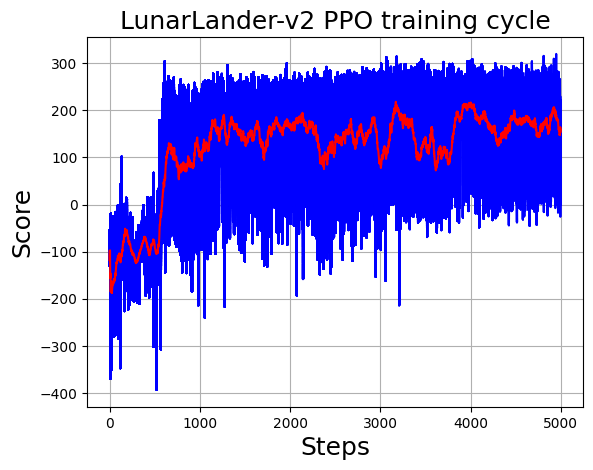

In [11]:
import random
import pylab
import numpy as np
import copy

import tensorflow as tf
from tensorboardX import SummaryWriter
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

import gym

class actor_model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Dense(512, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X_input)
        X = Dense(256, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        X = Dense(64, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.actor = Model(inputs = X_input, outputs = output)
        self.actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))
    
    #Loss function
    def ppo_loss(self, y_true, y_pred):
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks
        
        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)
        
        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value = 1 - LOSS_CLIPPING, max_value = 1 + LOSS_CLIPPING) * advantages
        
        actor_loss = -K.mean(K.minimum(p1, p2))
        
        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy
        
        return total_loss
    
    def predict(self, state):
        return self.actor.predict(state)


class critic_model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        old_values = Input(shape=(1,))
        
        X = Dense(512, activation="relu", kernel_initializer="he_uniform")(X_input)
        X = Dense(256, activation="relu", kernel_initializer="he_uniform")(X)
        X = Dense(64, activation="relu", kernel_initializer="he_uniform")(X)
        value = Dense(1, activation=None)(X)
        
        self.critic = Model(inputs=[X_input, old_values], outputs = value)
        self.critic.compile(loss=[self.critic_PPO2_loss(old_values)], optimizer=optimizer(lr=lr))
    
    #Loss function
    def critic_PPO2_loss(self, values):
        def loss(y_true, y_pred):
            LOSS_CLIPPING = 0.2
            clipped_value_loss = values + K.clip(y_pred - values, -LOSS_CLIPPING, LOSS_CLIPPING)
            v_loss1 = (y_true - clipped_value_loss) ** 2
            v_loss2 = (y_true - y_pred) ** 2
            
            value_loss = 0.5 * K.mean(K.maximum(v_loss1, v_loss2))
            return value_loss
        return loss
    
    def predict(self, state):
        return self.critic.predict([state, np.zeros((state.shape[0], 1))])


class model:
    def __init__(self, env_name):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.shape
        self.EPISODES = 5000 # total episodes to train through all environments
        self.episode = 0 # used to track the episodes total count of episodes played through all thread environments
        self.max_average = 0 # when average score is above 0 model will be saved
        self.lr = 0.00025
        self.epochs = 10 # training epochs
        self.shuffle=False
        self.training_batch = 1000
        self.optimizer = Adam

        self.replay_count = 0
        self.writer = SummaryWriter(comment="_"+self.env_name+"_"+self.optimizer.__name__+"_"+str(self.lr))
        
        # Instantiate plot memory
        self.scores_, self.episodes_, self.average_ = [], [], [] # used in matplotlib plots

        # Create Actor-Critic network models
        self.actor = actor_model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        self.critic = critic_model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        
        self.name = f"{self.env_name}_PPO"
        
    def act(self, state):
        #predict the next action to take, using the model
        prediction = self.actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        return action, action_onehot, prediction
    
    #Generalized Advantage Estimation
    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.9, normalize = True):
        deltas = [r + gamma * (1-d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas)-1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t+1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)
    
    def replay(self, states, actions, rewards, predictions, dones, next_states):
        #Reshape memory to approproate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        #Get Critic network predictions
        values = self.critic.predict(states)
        next_values = self.critic.predict(next_states)

        #Compute discounted rewards and advantages
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))

        #Stack everything to numpy array
        #Pack all advantags, predictions, and action to y_true and when they are received in custom PPO loss function we unpack it
        y_true = np.hstack([advantages, predictions, actions])

        #Training actor and critic networks
        a_loss = self.actor.actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
        c_loss = self.critic.critic.fit([states, values], target, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
    
    #Save weights to file
    def save(self, name):
        self.actor.actor.save_weights(name+"_Actor.h5")
        self.critic.critic.save_weights(name+"_Critic.h5")
    
    #Load weights from file
    def load(self, actor_weights_name, critic_weights_name):
        self.actor.actor.load_weights(actor_weights_name)
        self.critic.critic.load_weights(critic_weights_name)
    
    #Save the model when it performs the best
    def save_best(self, score, episode):
        self.scores_.append(score)
        self.episodes_.append(episode)
        self.average_.append(sum(self.scores_[-50:]) / len(self.scores_[-50:]))
        
        #Save and plot every 100 episodes
        if str(episode)[-2:] == "00":
            self.save(self.name+"_Episode"+str(episode))
            
            pylab.plot(self.episodes_, self.scores_, 'b')
            pylab.plot(self.episodes_, self.average_, 'r')
            pylab.title(self.env_name+" PPO training cycle", fontsize=18)
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.grid(True)
                pylab.savefig(self.env_name+".png")
            except OSError:
                pass
        
        #Save best models
        if self.average_[-1] >= self.max_average:
            self.max_average = self.average_[-1]
            
            self.save(self.name)
            SAVING = "SAVING"
            
            #Learning rate decay
            self.lr *= 0.95
            K.set_value(self.actor.actor.optimizer.learning_rate, self.lr)
            K.set_value(self.critic.critic.optimizer.learning_rate, self.lr)
        else:
            SAVING = ""
        
        return self.average_[-1], SAVING
    
    #Train the model
    def run_batch(self):
        score_array, avg_array, fuel_array = [], [], []
        successCount = 0
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size[0]])
        done, score, SAVING, = False, 0, ''

        while True:
            #Initialize or reset memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            timesteps = 0
            for t in range(self.training_batch):
                timesteps += 1
                #self.env.render()
                action, action_onehot, prediction = self.act(state)
                next_state, reward, done, _ = self.env.step(action)

                states.append(state)
                next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)

                state = np.reshape(next_state, [1, self.state_size[0]])
                score += reward

                if done or timesteps > 1000:
                    timesteps = 0
                    self.episode += 1
                    average, SAVING = self.save_best(score, self.episode)
                    score_array.append(score)
                    avg_array.append(average)
                    if score >= 200:
                        successCount += 1
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))

                    state, done, score, SAVING = self.env.reset(), False, 0, ''
                    state = np.reshape(state, [1, self.state_size[0]])
                    
                    if self.episode == self.EPISODES:
                        return score_array, avg_array, successCount
                    
            self.replay(states, actions, rewards, predictions, dones, next_states)
    
    #Run the model
    def run(self, num):
        for i in range(num):
            state = self.env.reset()
            state=np.reshape(state, [1, self.state_size[0]])
            done = False
            score = 0
            
            for t in range(1000):
                self.env.render()
                action = np.argmax(self.actor.predict(state)[0])
                state, reward, done, _ = self.env.step(action)
                state = np.reshape(state, [1, self.state_size[0]])
                score += reward

                if done:
                    break
            
            print("Score:", score)
                    
        self.env.close()


#TRAIN THE MODEL
env = "LunarLander-v2"
agent = model(env)
score_array, avg_array, successCount = agent.run_batch()

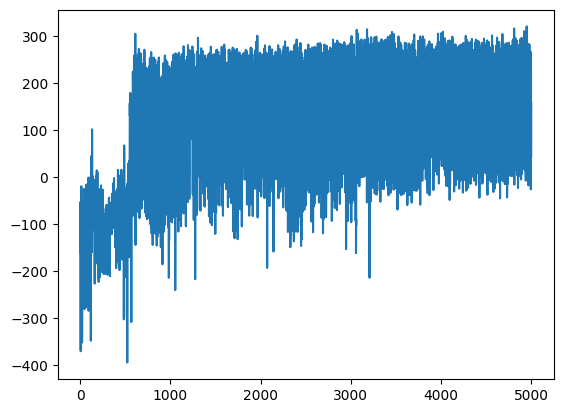

In [13]:
import matplotlib.pyplot as plt
plt.plot(score_array)

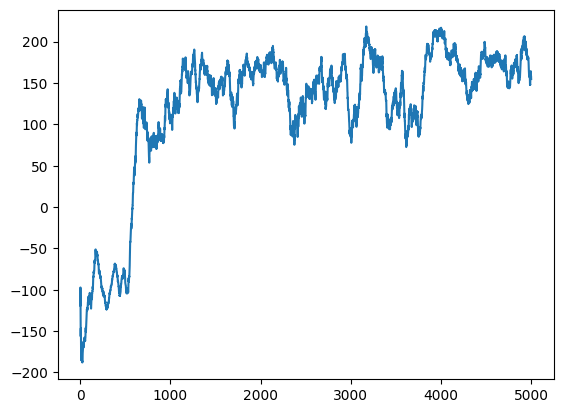

In [12]:
plt.plot(avg_array)